## Final Project Submission

* Student name: Hoang Nguyen, Madoria Thomas, Marcelo Scatena
* Student pace: full time
* Scheduled project review date: 07/01/2021
* Instructor name: Skyler English


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error
from yellowbrick.features import Rank2D
# from ipynb.fs.full.cleaning_data import clean_data
from geopy import distance
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df_ref = pd.read_csv('data/kc_house_data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

### Split Data into Test and Train

In [5]:
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

In [6]:
# We'll use df as our train dataset
y = y_train
X_train['price'] = y
df = X_train

### Find out where my missing values and fill them to make a first model with all the information we can:

In [7]:
df.isnull().sum()

id                  0
date                0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1897
view               53
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3059
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
price               0
dtype: int64

In [8]:
df['view'].value_counts()

NONE         15556
AVERAGE        753
GOOD           395
EXCELLENT      263
FAIR           257
Name: view, dtype: int64

In [9]:
df['view'].fillna('NONE', inplace=True)

In [10]:
df['waterfront'].value_counts()

NO     15262
YES      118
Name: waterfront, dtype: int64

In [11]:
df['waterfront'].fillna('NO', inplace=True)

In [12]:
df['yr_renovated'].value_counts() 

0.0       13625
2014.0       56
2005.0       27
2007.0       24
2003.0       24
          ...  
1976.0        1
1959.0        1
1953.0        1
1950.0        1
1954.0        1
Name: yr_renovated, Length: 68, dtype: int64

In [13]:
df['yr_renovated'].fillna(0.0, inplace=True)

### Change all our objects into numeric values:

In [14]:
# Convert grade to int
df['grade'] = df['grade'].apply(lambda x: x[:2] if x[0]=='1' else x[:1]).astype('int64')

In [15]:
# Remove ? and convert sqft_basement to int
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: 0 if x=='?' else int(x.split('.')[0]))

In [16]:
# Change waterfront to numeric
df['waterfront'] = df['waterfront'].apply(lambda x: 1 if x=='YES' else 0)

In [17]:
df['view'].unique()

array(['NONE', 'AVERAGE', 'GOOD', 'EXCELLENT', 'FAIR'], dtype=object)

In [18]:
# Change view to numeric
df['view'] = df['view'].apply(lambda x: 0 if x=='NONE' else (1 if x=='FAIR' else (2 if x=='AVERAGE' else (3 if x=='GOOD' else 4))))

In [19]:
df['condition'].unique()

array(['Good', 'Average', 'Very Good', 'Fair', 'Poor'], dtype=object)

In [20]:
# Change condition to numeric
df['condition'] = df['condition'].apply(lambda x: 1 if x=='Poor' else (2 if x=='Fair' else (3 if x=='Average' else (4 if x=='Good' else 5))))

In [21]:
#Convert date column to 2 separate columns for month and year
date = df['date'].str.split('/', expand=True)
df['month_sold'] = date[0].astype('int64')
df['year_sold'] = date[2].astype('int64')

#Drop original date column
df.drop(columns=['date'], axis=1, inplace=True)

In [22]:
df.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,month_sold,year_sold
6243,9834201100,4,2.00,1440,4855,2.0,0,0,4,7,...,1972,0.0,98144,47.5717,-122.287,1300,4080,332500.0,12,2014
8986,7795810110,3,1.75,1430,9857,1.0,0,2,4,7,...,1980,0.0,98045,47.4964,-121.771,1310,9880,390000.0,5,2015
9419,1853081250,4,2.75,3120,5000,2.0,0,0,3,9,...,2010,0.0,98074,47.5940,-122.062,3200,5000,800000.0,12,2014
10155,2558630350,4,2.50,2060,6958,1.0,0,0,3,7,...,1974,0.0,98034,47.7251,-122.168,1760,7350,462000.0,3,2015
10436,3362401000,3,2.00,2500,4080,1.5,0,0,5,7,...,1922,0.0,98103,47.6813,-122.346,1550,3060,695000.0,7,2014


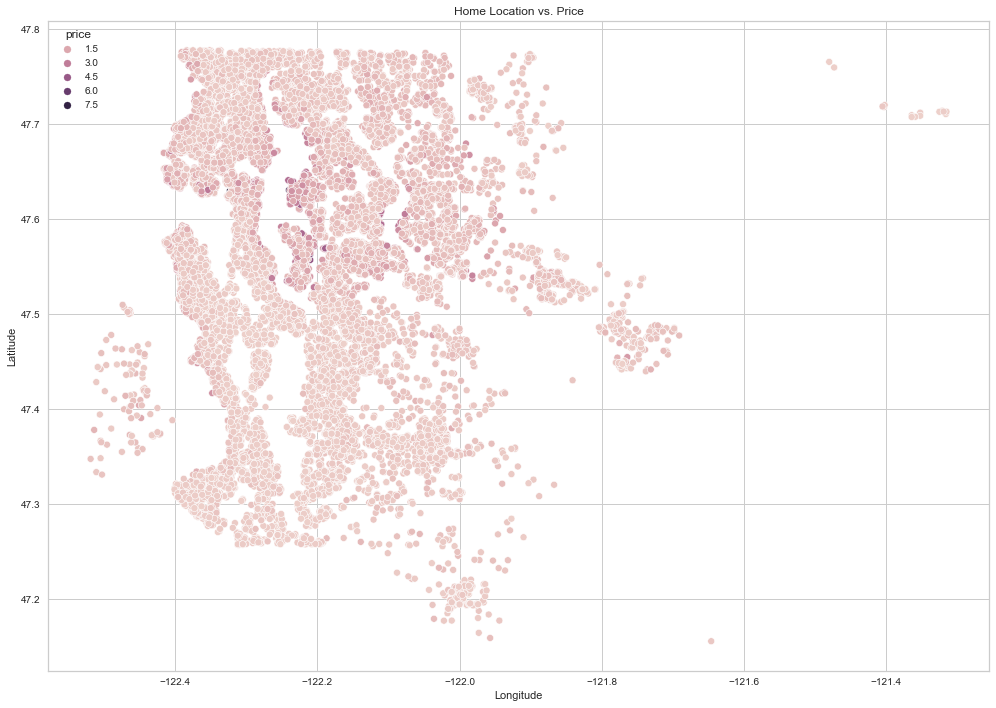

In [23]:
plt.figure(figsize=(14, 10))
plt.title('Home Location vs. Price')
sns.scatterplot(df['long'], df['lat'], hue=df['price'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# Model 1 - Using All Features

In [24]:
X = df.drop('price', axis=1)
y = df['price']
model_1 = sm.OLS(y, sm.add_constant(X)).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     1946.
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        10:39:33   Log-Likelihood:            -2.3549e+05
No. Observations:               17277   AIC:                         4.710e+05
Df Residuals:                   17255   BIC:                         4.712e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.024e+07   1.11e+07     -6.316      0.000    -9.2e+07   -4.84e+07
id            -1.756e-06   5.38e-07     -3.262      0.001   -2.81e-06   -7.01e-07
bedrooms      -3.898e+04   2208.241    -17.652      0.000   -4.33e+04   -3.47e+04
bathrooms      4.258e+04   3669.369     11.605      0.000    3.54e+04    4.98e+04
sqft_living     101.3979     21.483      4.720      0.000      59.289     143.507
sqft_lot          0.0878      0.055      1.606      0.108      -0.019       0.195
floors         9946.9534   4024.590      2.472      0.013    2058.348    1.78e+04
waterfront     6.041e+05   2.02e+04     29.925      0.000    5.65e+05    6.44e+05
view           5.253e+04   2374.225     22.125      0.000    4.79e+04    5.72e+04
condition       2.98e+04   2626.080     11.347      0.000    2.47e+04    3.49e+04
grade          9.905e+04   2415.860     41.002      0.000    9.43e+04    1.04e+05
sqft_above       78.2646     21.420      3.654      0.000      36.279     120.250
sqft_basement    52.3378     21.253      2.463      0.014      10.679      93.996
yr_built      -2696.8508     80.408    -33.540      0.000   -2854.459   -2539.243
yr_renovated     22.9471      4.454      5.152      0.000      14.217      31.678
zipcode        -564.7472     36.869    -15.318      0.000    -637.014    -492.480
lat            5.897e+05    1.2e+04     49.016      0.000    5.66e+05    6.13e+05
long          -2.078e+05   1.46e+04    -14.210      0.000   -2.36e+05   -1.79e+05
sqft_living15    24.7295      3.883      6.369      0.000      17.119      32.340
sqft_lot15       -0.4617      0.082     -5.631      0.000      -0.622      -0.301
month_sold     1435.9748    789.356      1.819      0.069    -111.243    2983.192
year_sold      3.812e+04   5268.577      7.235      0.000    2.78e+04    4.84e+04
==============================================================================
Omnibus:                    14849.799   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1493773.020
Skew:                           3.630   Prob(JB):                         0.00
Kurtosis:                      47.970   Cond. No.                     3.94e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.94e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
def clean_data_model_1(df):
    # Fill NaN values with most commom occurances
    df['view'].fillna('NONE', inplace=True)
    df['waterfront'].fillna('NO', inplace=True)
    df['yr_renovated'].fillna(0.0, inplace=True)
    # Convert grade to int
    df['grade'] = df['grade'].apply(lambda x: x[:2] if x[0]=='1' else x[:1]).astype('int64')
    # Remove ? and convert sqft_basement to int
    df['sqft_basement'] = df['sqft_basement'].apply(lambda x: 0 if x=='?' else int(x.split('.')[0]))
    # Change waterfront to numeric
    df['waterfront'] = df['waterfront'].apply(lambda x: 1 if x=='YES' else 0)
    # Change view to numeric
    df['view'] = df['view'].apply(lambda x: 0 if x=='NONE' else (1 if x=='FAIR' else (2 if x=='AVERAGE' else (3 if x=='GOOD' else 4))))
    # Change condition to numeric
    df['condition'] = df['condition'].apply(lambda x: 1 if x=='Poor' else (2 if x=='Fair' else (3 if x=='Average' else (4 if x=='Good' else 5))))
    #Convert date column to 2 separate columns for month and year
    date = df['date'].str.split('/', expand=True)
    df['month_sold'] = date[0].astype('int64')
    df['year_sold'] = date[2].astype('int64')
    #Drop original date column
    df.drop(columns=['date'], axis=1, inplace=True)
    
    return df

In [26]:
LR = LinearRegression()
LR.fit(X,y)

LinearRegression()

In [27]:
to_clean = X_test
X_test['price'] = y_test

In [28]:
# Clean test according to cahnges so far
cleaned_X_test_1 = clean_data_model_1(to_clean)

In [29]:
y_test = cleaned_X_test_1['price']
X_test = cleaned_X_test_1.drop('price', axis=1)

In [30]:
y_prediction =  LR.predict(X_test)
y_prediction

array([ 95465.40946384, 380892.32744573, 217276.84544538, ...,
       490317.90519959, 338029.81792328, 229569.37989525])

In [31]:
rms = mean_squared_error(y_test, y_prediction, squared=False)

In [32]:
rms

199177.3275030161

In [33]:
df_2 = df.copy()

#### Our error so far is in near $200,000, which is not good for our model

# Checking our Assumptions

## Normality

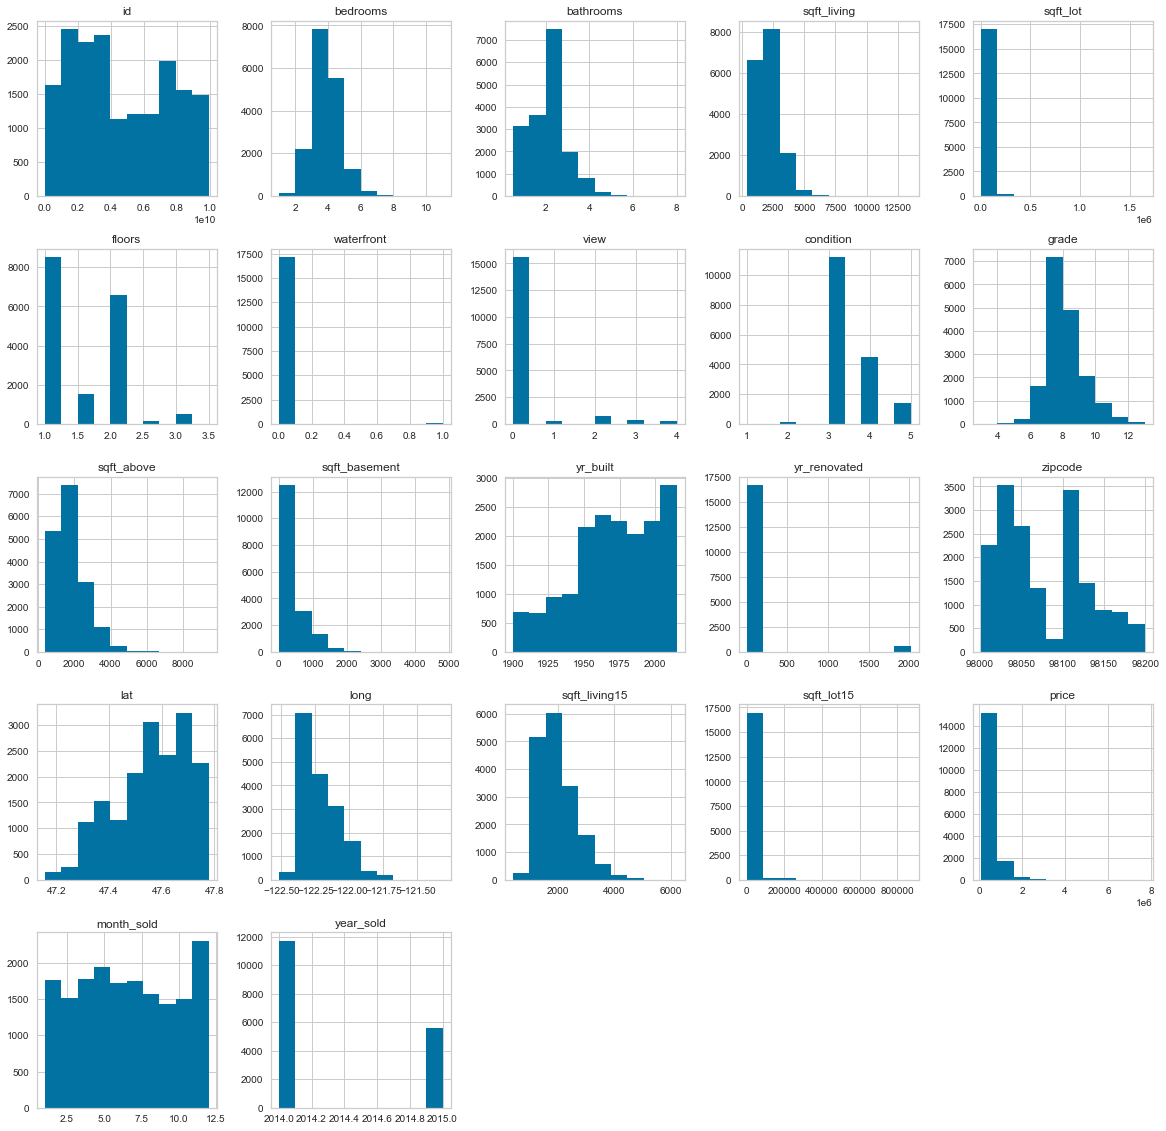

In [34]:
df_2.hist(figsize=(20,20));

None of these variables seem to follow a normal distribution. While this may create problems satisfying all assumptions, we'll first take a look at the other assumptions to see if there are any obvious changes to me made.

For now we'll use a QQ Plot to confirm that our assesment is correct.

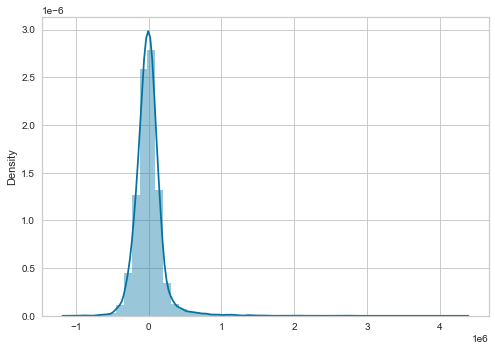

In [35]:
sns.distplot(model_1.resid);

<Figure size 864x576 with 0 Axes>

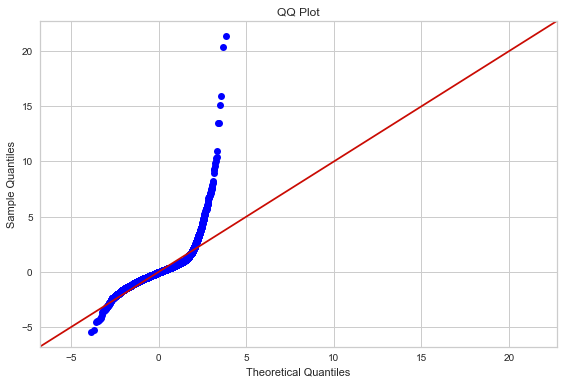

In [36]:
plt.figure(figsize=(12, 8))
fig = sm.graphics.qqplot(model_1.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.tight_layout();

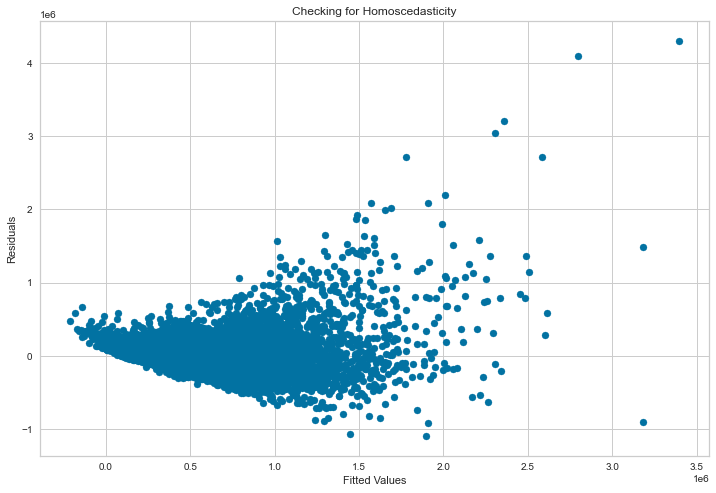

In [37]:
plt.figure(figsize=(12, 8))
plt.scatter(model_1.predict(), model_1.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Checking for Homoscedasticity');

## Further EDA and dealing with some outliers and rounding decimals

In [38]:
df_2['bedrooms'].value_counts()

3     7836
4     5542
2     2189
5     1281
6      216
1      161
7       35
8       10
9        4
10       2
11       1
Name: bedrooms, dtype: int64

In [39]:
# Remove the few houses with high number of bedrooms
df_2 = df_2[~df_2['bedrooms'].isin([11, 10, 9])]

#### Turn Bathrooms column into wc_comp and wc_inc:

In [40]:
df_2['bathrooms'].value_counts()

2.50    4322
1.00    3076
1.75    2446
2.25    1646
2.00    1526
1.50    1168
2.75     933
3.00     593
3.50     583
3.25     465
3.75     120
4.00     111
4.50      82
4.25      66
0.75      59
4.75      20
5.00      17
5.25       9
1.25       5
5.50       5
0.50       4
5.75       3
6.00       3
8.00       2
6.75       2
6.50       2
7.75       1
6.25       1
Name: bathrooms, dtype: int64

In [41]:
df_2['bathrooms'] = df_2['bathrooms'].apply(lambda x: np.ceil(x) if str(x)[2] == '7' else (np.ceil(x) if str(x)[2] == '5' else np.floor(x)))

In [42]:
df_2['bathrooms'].value_counts()

2.0    6786
3.0    6313
1.0    3144
4.0     880
5.0     128
6.0      12
7.0       4
8.0       3
Name: bathrooms, dtype: int64

In [43]:
df_2 = df_2[~df_2['bathrooms'].isin([8.0, 7.0])]

#### Changed Floor column:

In [44]:
df_2['floors'].value_counts()

1.0    8530
2.0    6571
1.5    1532
3.0     498
2.5     125
3.5       7
Name: floors, dtype: int64

In [45]:
df_2['floors'] = df_2['floors'].apply(lambda x: np.ceil(x))

In [46]:
df_2 = df_2[df_2['long'] < -121.647]

# Model 2 - Changing features and removing outliers

In [47]:
X = df_2.drop('price', axis=1)
y = df_2['price']
model_2 = sm.OLS(y, sm.add_constant(X)).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     1952.
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        10:39:37   Log-Likelihood:            -2.3462e+05
No. Observations:               17247   AIC:                         4.693e+05
Df Residuals:                   17225   BIC:                         4.695e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.117e+07   1.08e+07     -6.568      0.000   -9.24e+07   -4.99e+07
id            -1.974e-06   5.25e-07     -3.761      0.000      -3e-06   -9.45e-07
bedrooms      -3.295e+04   2173.879    -15.158      0.000   -3.72e+04   -2.87e+04
bathrooms      1.246e+04   3001.710      4.150      0.000    6572.846    1.83e+04
sqft_living     112.9373     20.884      5.408      0.000      72.003     153.871
sqft_lot          0.1101      0.053      2.069      0.039       0.006       0.214
floors         1.905e+04   3453.955      5.515      0.000    1.23e+04    2.58e+04
waterfront     6.044e+05   1.97e+04     30.626      0.000    5.66e+05    6.43e+05
view           5.153e+04   2315.661     22.251      0.000     4.7e+04    5.61e+04
condition      3.142e+04   2557.454     12.287      0.000    2.64e+04    3.64e+04
grade          1.025e+05   2355.719     43.529      0.000    9.79e+04    1.07e+05
sqft_above       62.9820     20.846      3.021      0.003      22.122     103.842
sqft_basement    47.7328     20.698      2.306      0.021       7.163      88.302
yr_built      -2429.2315     77.225    -31.457      0.000   -2580.600   -2277.863
yr_renovated     24.6817      4.338      5.689      0.000      16.179      33.185
zipcode        -558.5259     35.933    -15.544      0.000    -628.957    -488.094
lat            5.932e+05   1.17e+04     50.630      0.000     5.7e+05    6.16e+05
long          -2.065e+05   1.46e+04    -14.153      0.000   -2.35e+05   -1.78e+05
sqft_living15    30.7172      3.818      8.045      0.000      23.233      38.201
sqft_lot15       -0.4585      0.080     -5.740      0.000      -0.615      -0.302
month_sold     1323.3460    769.291      1.720      0.085    -184.542    2831.234
year_sold      3.801e+04   5134.844      7.402      0.000    2.79e+04    4.81e+04
==============================================================================
Omnibus:                    12471.701   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           568433.759
Skew:                           2.981   Prob(JB):                         0.00
Kurtosis:                      30.486   Cond. No.                     3.94e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.94e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
def clean_data_model_2(df):
    
    df = df[~df['bedrooms'].isin([11, 10, 9])]
    df['bathrooms'] = df['bathrooms'].apply(lambda x: np.ceil(x) if str(x)[2] == '7' else (np.ceil(x) if str(x)[2] == '5' else np.floor(x)))
    df = df[~df['bathrooms'].isin([8.0, 7.0])]
    df['floors'] = df['floors'].apply(lambda x: np.ceil(x))
    df = df[df['long'] < -121.647]
    
    return df

In [49]:
LR = LinearRegression()
LR.fit(X,y)

LinearRegression()

In [50]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test
to_clean['price'] = y_test

# Clean test according to cahnges so far
cleaned_X_test_2 = clean_data_model_2(to_clean)

y_test = cleaned_X_test_2['price']
X_test = cleaned_X_test_2.drop('price', axis=1)

y_prediction =  LR.predict(X_test)
y_prediction

rms = mean_squared_error(y_test, y_prediction, squared=False)
rms

199820.26823891135

In [51]:
df_3 = df_2.copy()

## Variable Correlations

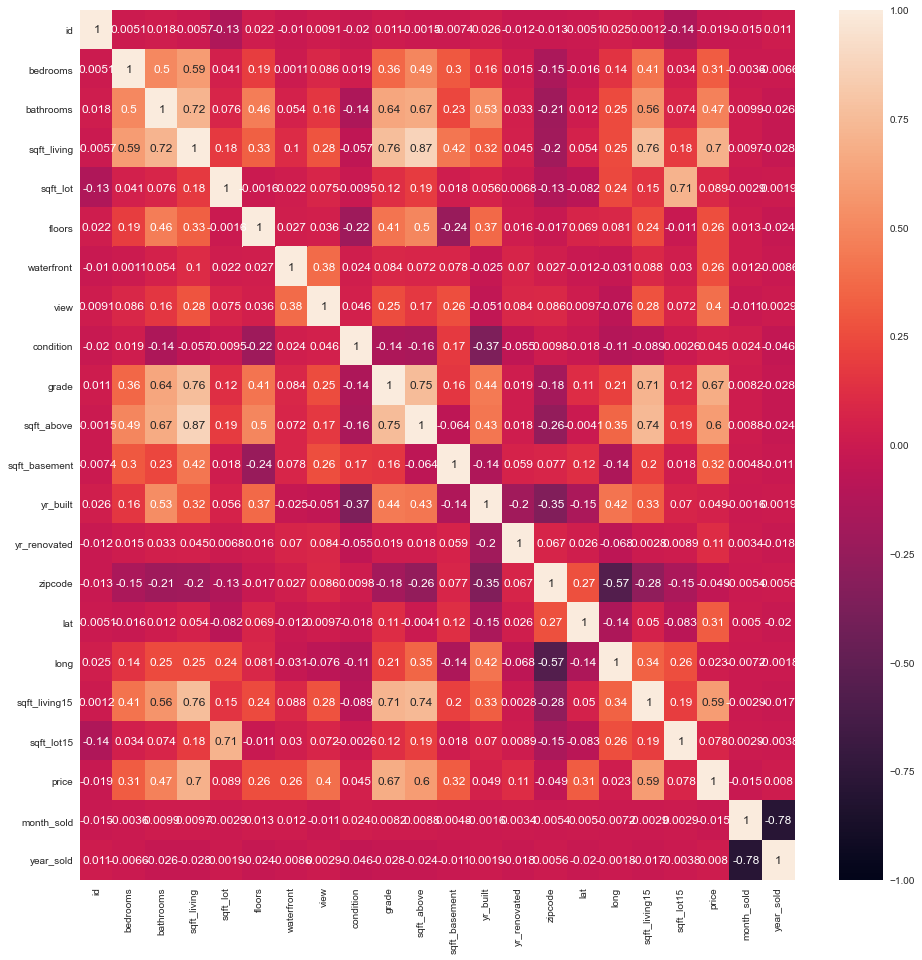

In [52]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(df_3.corr(), vmin=-1, vmax=1, annot=True);

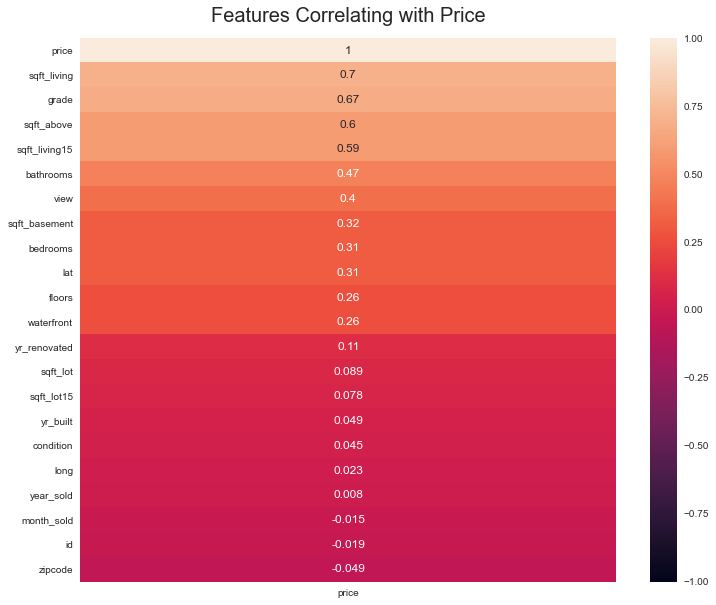

In [53]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(df_3.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':20}, pad=16);

Of the features most correlated with Price, a few of them are regarding to the size of the property and surrounding ones (sqft_living, sqft_living15, sqft_above, number of bathrooms)

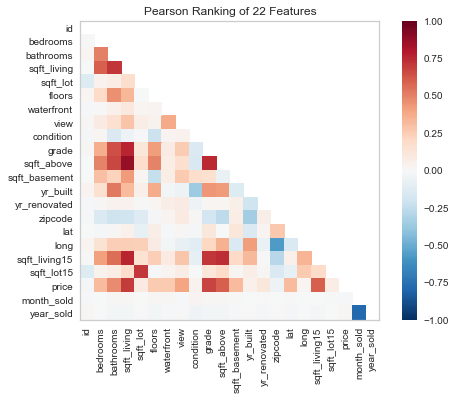

In [54]:
visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(df_3)
visualizer.show();

In [55]:
# Drop some highly correlated columns
df_3.drop(['grade', 'sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)

In [56]:
# Drop uncorrelated columns
df_3.drop(['id', 'year_sold', 'month_sold', 'zipcode'], axis=1, inplace=True)

# Model 3 - Addressing multicolinearity

In [57]:
X = df_3.drop('price', axis=1)
y = df_3['price']
model_3 = sm.OLS(y, sm.add_constant(X)).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     2515.
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        10:39:43   Log-Likelihood:            -2.3595e+05
No. Observations:               17247   AIC:                         4.719e+05
Df Residuals:                   17233   BIC:                         4.720e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.742e+07   1.81e+06    -26.198      0.000    -5.1e+07   -4.39e+07
bedrooms      -4.672e+04   2314.474    -20.188      0.000   -5.13e+04   -4.22e+04
bathrooms      2.182e+04   3230.464      6.754      0.000    1.55e+04    2.82e+04
sqft_living     294.9430      3.189     92.501      0.000     288.693     301.193
sqft_lot         -0.1170      0.042     -2.771      0.006      -0.200      -0.034
floors         2.028e+04   3656.037      5.548      0.000    1.31e+04    2.74e+04
waterfront     5.752e+05   2.13e+04     27.021      0.000    5.33e+05    6.17e+05
view           6.608e+04   2438.741     27.095      0.000    6.13e+04    7.09e+04
condition      3.579e+04   2738.298     13.069      0.000    3.04e+04    4.12e+04
sqft_basement   -64.7601      4.924    -13.153      0.000     -74.411     -55.109
yr_built      -1396.2751     80.252    -17.399      0.000   -1553.577   -1238.973
yr_renovated     30.5507      4.675      6.534      0.000      21.386      39.715
lat            6.549e+05   1.21e+04     53.936      0.000    6.31e+05    6.79e+05
long          -1.547e+05   1.38e+04    -11.245      0.000   -1.82e+05   -1.28e+05
==============================================================================
Omnibus:                    11070.958   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           348837.198
Skew:                           2.601   Prob(JB):                         0.00
Kurtosis:                      24.409   Cond. No.                     4.82e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.82e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
def clean_data_model_3(df):
    df.drop(['grade', 'sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)
    df.drop(['id', 'year_sold', 'month_sold', 'zipcode'], axis=1, inplace=True)
    return df

In [59]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test
to_clean['price'] = y_test

# Clean test according to cahnges so far
cleaned_X_test_3 = clean_data_model_3(to_clean)

y_test = cleaned_X_test_3['price']
X_test = cleaned_X_test_3.drop('price', axis=1)

y_prediction =  LR.predict(X_test)
y_prediction

rms = mean_squared_error(y_test, y_prediction, squared=False)
rms

211795.9999750595

In [60]:
df_4 = df_3.copy()

## Feature Engineering 1

In [61]:
def distance_from(lat, long, series_lat, series_long):
    lat_long = series_lat.astype(str) + ',' + series_long.astype(str)
    lat_long = list(map(eval, lat_long))
    coordinates = (lat, long)
    miles = []
    for i in lat_long:
        miles.append(round(distance.distance(i, coordinates).miles, 1))
    series = pd.DataFrame(miles)
    return series

In [62]:
# df['distance_seattle'] = distance_from(47.6062, -122.3321, df['lat'], df['long'])
# df['distance_redmond'] = distance_from(47.6740, -122.1215, df['lat'], df['long'])

In [63]:
lat_long = df_4['lat'].astype(str) + ',' + df_4['long'].astype(str)
lat_long = list(map(eval, lat_long))
Seattle = (47.6062, -122.3321)
Redmond = (47.6740, -122.1215)
Kent = (47.3809, -122.2348)
miles_s = []
miles_r = []
miles_k = []
for i in lat_long:
    miles_s.append(round(distance.distance(i, Seattle).miles, 1))
    miles_r.append(round(distance.distance(i, Redmond).miles, 1))
    miles_k.append(round(distance.distance(i, Kent).miles, 1))
df_4['distance_seattle'] = miles_s
df_4['distance_redmond'] = miles_r
df_4['distance_kent'] = miles_k

Since we created new columns using location information, we can drop the latitude, longitude and zipcode columns.

In [64]:
df_4.drop(['lat', 'long'], axis=1, inplace=True)

In [65]:
# Create column with rencent builds
df_4['recent_build'] = df_4['yr_built'].apply(lambda x: 1 if x > 2010 else 0)

In [66]:
df_4.drop(['yr_built'], axis=1, inplace=True)

# Model 4 - With Feature Engineering Done

In [67]:
X = df_4.drop('price', axis=1)
y = df_4['price']
model_4 = sm.OLS(y, sm.add_constant(X)).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     2829.
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        10:39:55   Log-Likelihood:            -2.3483e+05
No. Observations:               17247   AIC:                         4.697e+05
Df Residuals:                   17232   BIC:                         4.698e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2.947e+04   1.38e+04      2.143      0.032    2511.212    5.64e+04
bedrooms         -3.939e+04   2161.010    -18.230      0.000   -4.36e+04   -3.52e+04
bathrooms         7588.9288   2775.912      2.734      0.006    2147.858     1.3e+04
sqft_living        300.3834      3.031     99.116      0.000     294.443     306.324
sqft_lot             0.1861      0.040      4.661      0.000       0.108       0.264
floors           -1.625e+04   3530.937     -4.602      0.000   -2.32e+04   -9328.585
waterfront        5.976e+05      2e+04     29.923      0.000    5.58e+05    6.37e+05
view              6.419e+04   2293.352     27.990      0.000    5.97e+04    6.87e+04
condition         4.631e+04   2437.822     18.997      0.000    4.15e+04    5.11e+04
sqft_basement      -97.0053      4.703    -20.628      0.000    -106.223     -87.788
yr_renovated        42.4245      4.224     10.043      0.000      34.144      50.705
distance_seattle  -1.65e+04    344.965    -47.836      0.000   -1.72e+04   -1.58e+04
distance_redmond -2368.1394    389.371     -6.082      0.000   -3131.345   -1604.933
distance_kent     5840.6247    295.631     19.756      0.000    5261.158    6420.091
recent_build      2.224e+04   7198.798      3.089      0.002    8128.510    3.63e+04
==============================================================================
Omnibus:                    11713.619   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           444026.593
Skew:                           2.766   Prob(JB):                         0.00
Kurtosis:                      27.234   Cond. No.                     5.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [68]:
def clean_data_model_4(df):
    
    lat_long = df['lat'].astype(str) + ',' + df['long'].astype(str)
    lat_long = list(map(eval, lat_long))
    Seattle = (47.6062, -122.3321)
    Redmond = (47.6740, -122.1215)
    Kent = (47.3809, -122.2348)
    miles_s = []
    miles_r = []
    miles_k = []
    for i in lat_long:
        miles_s.append(round(distance.distance(i, Seattle).miles, 1))
        miles_r.append(round(distance.distance(i, Redmond).miles, 1))
        miles_k.append(round(distance.distance(i, Kent).miles, 1))
    df['distance_seattle'] = miles_s
    df['distance_redmond'] = miles_r
    df['distance_kent'] = miles_k
    
    df.drop(['lat', 'long'], axis=1, inplace=True)
    df['recent_build'] = df['yr_built'].apply(lambda x: 1 if x > 2010 else 0)
    df.drop(['yr_built'], axis=1, inplace=True)
    
    return df

In [69]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test
to_clean['price'] = y_test

# Clean test according to cahnges so far
cleaned_X_test_4 = clean_data_model_4(to_clean)

y_test = cleaned_X_test_4['price']
X_test = cleaned_X_test_4.drop('price', axis=1)

y_prediction =  LR.predict(X_test)
y_prediction

rms = mean_squared_error(y_test, y_prediction, squared=False)
rms

198427.38735184754

In [70]:
df_5 = df_4.copy()

## Extended EDA

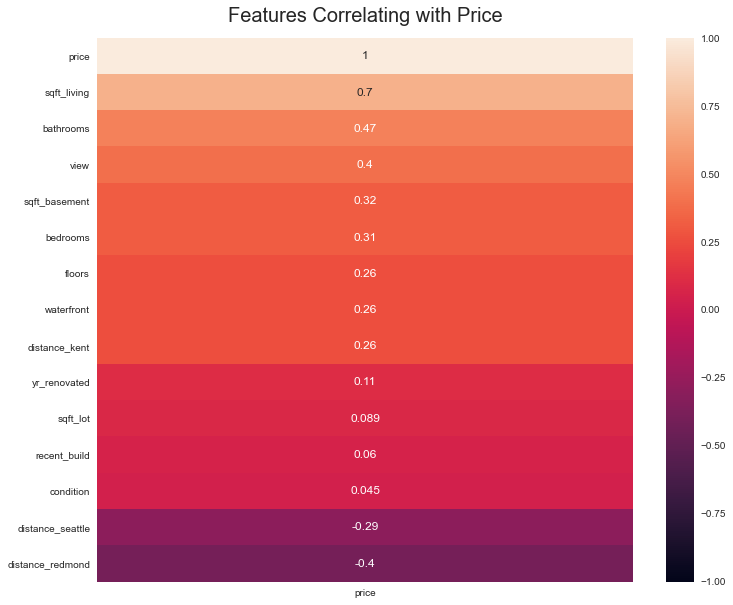

In [71]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(df_5.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':20}, pad=16);

In [72]:
# Drop some highly correlated columns or with near zero correlation with price
df_5.drop(['condition', 'sqft_lot', 'yr_renovated', 'bathrooms', 'recent_build'], axis=1, inplace=True)

In [73]:
# Drop outlier
df_5 = df_5[df_5['price'] < 5000000]
df_5 = df_5[df_5['sqft_basement'] < 3000]

## Model 5

In [74]:
X = df_5.drop('price', axis=1)
y = df_5['price']
model_5 = sm.OLS(y, sm.add_constant(X)).fit()
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     4248.
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        10:39:59   Log-Likelihood:            -2.3468e+05
No. Observations:               17243   AIC:                         4.694e+05
Df Residuals:                   17233   BIC:                         4.695e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.971e+05   1.04e+04     18.950      0.000    1.77e+05    2.17e+05
bedrooms         -3.503e+04   2121.928    -16.507      0.000   -3.92e+04   -3.09e+04
sqft_living        299.0038      2.668    112.068      0.000     293.774     304.234
floors            -2.01e+04   3263.886     -6.157      0.000   -2.65e+04   -1.37e+04
waterfront         5.81e+05      2e+04     29.031      0.000    5.42e+05     6.2e+05
view               6.81e+04   2280.610     29.861      0.000    6.36e+04    7.26e+04
sqft_basement      -90.1285      4.634    -19.447      0.000     -99.212     -81.044
distance_seattle -1.665e+04    332.523    -50.086      0.000   -1.73e+04    -1.6e+04
distance_redmond -1994.0113    384.416     -5.187      0.000   -2747.505   -1240.517
distance_kent     5994.8628    292.448     20.499      0.000    5421.635    6568.091
==============================================================================
Omnibus:                    10165.879   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           232732.370
Skew:                           2.401   Prob(JB):                         0.00
Kurtosis:                      20.346   Cond. No.                     3.06e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [75]:
def clean_data_model_5(df):
    df.drop(['condition', 'sqft_lot', 'yr_renovated', 'bathrooms', 'recent_build'], axis=1, inplace=True)
    df = df[df['price'] < 4000000]
    df = df[df['sqft_basement'] < 3000]
    
    return df

In [76]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test
to_clean['price'] = y_test

# Clean test according to cahnges so far
cleaned_X_test_5 = clean_data_model_5(to_clean)

y_test = cleaned_X_test_5['price']
X_test = cleaned_X_test_5.drop('price', axis=1)

y_prediction =  LR.predict(X_test)
y_prediction

rms = mean_squared_error(y_test, y_prediction, squared=False)
rms

188938.44484493096

In [77]:
df_6 = df_5.copy()

In [78]:
# features = np.array([bedrooms, sqft_living, floors, waterfront, view, sqft_basement, distance_seattle, distance_redmond], dtype=float)

features = np.array([3, 1510, 1, 0, 0, 650, 6.3, 9.6, 2], dtype=float)

formula = LR.intercept_ + (np.dot(LR.coef_, features))
formula

352726.14195433416

In [79]:
Seattle = (47.6062, -122.3321)
Redmond = (47.6740, -122.1215)

In [80]:
# fig, ax = plt.subplots(figsize=(12, 10))
# plt.title('Home Location vs. Price')
# sns.scatterplot(df['long'], df['lat'], hue=df_5['distance_redmond'], ax=ax)#, palette='RdBu', alpha=0.3)
# sns.scatterplot(df['long'], df['lat'], hue=df_5['distance_seattle'], alpha=.3, ax=ax)#, palette='RdBu', alpha=0.3)
# sns.scatterplot(df['long'], df['lat'], hue=df_5['distance_kent'], alpha=1, ax=ax)
# ax.plot(-122.3321, 47.6062, 'ro')
# ax.plot(-122.1215, 47.6740, 'bo')
# ax.plot(-122.2348, 47.3809, 'bo')
# # sns.scatterplot(47.6062, -122.3321)#, color='g', marker='*')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.legend(['Seattle','Redmond'])
# plt.tight_layout()

<Figure size 576x396 with 0 Axes>

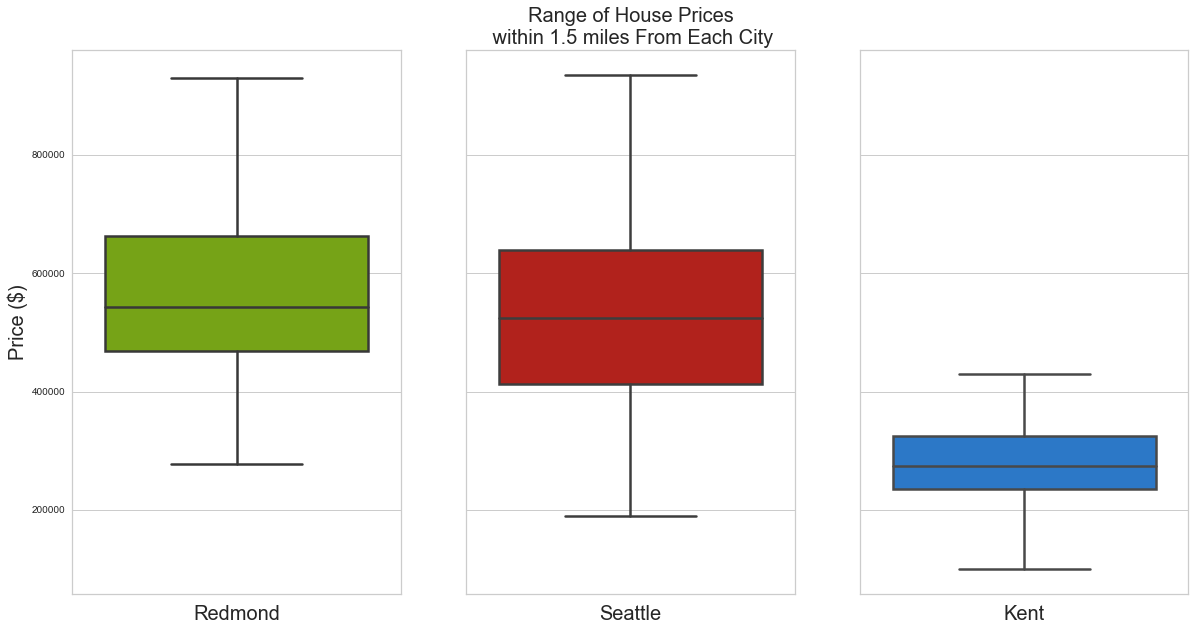

In [106]:
dist_kent = df_5[df_5['distance_kent'] <= 1.5].sort_values(by='price', ascending=False)
dist_redmond = df_5[df_5['distance_redmond'] <= 1.5].sort_values(by='price', ascending=False)
dist_seattle = df_5[df_5['distance_seattle'] <= 1.5].sort_values(by='price', ascending=False)

fig = plt.figure()
fig, axes = plt.subplots(nrows = 1, ncols = 3, sharex=False, sharey=True, figsize=(20,10), squeeze=False)

sns.boxplot(y="price", data=dist_redmond, ax=axes[0][0], linewidth=2.5, color="#7FBA00", showfliers=False)
sns.boxplot(y="price", data=dist_seattle, ax=axes[0][1], linewidth=2.5, color="r", showfliers=False)
sns.boxplot(y="price", data=dist_kent, ax=axes[0][2], linewidth=2.5, color="#1277e1", showfliers=False)

axes[0][0].set_ylabel('Price ($)', fontsize=20)
axes[0][1].set_ylabel('')
axes[0][2].set_ylabel('')
axes[0][0].set_xlabel('Redmond', fontsize=20)
axes[0][1].set_xlabel('Seattle', fontsize=20)
axes[0][2].set_xlabel('Kent', fontsize=20)
axes[0][1].set_title('Range of House Prices\n within 1.5 miles From Each City', fontsize=20);

# plt.savefig('price_dist_1', bbox_inches='tight');

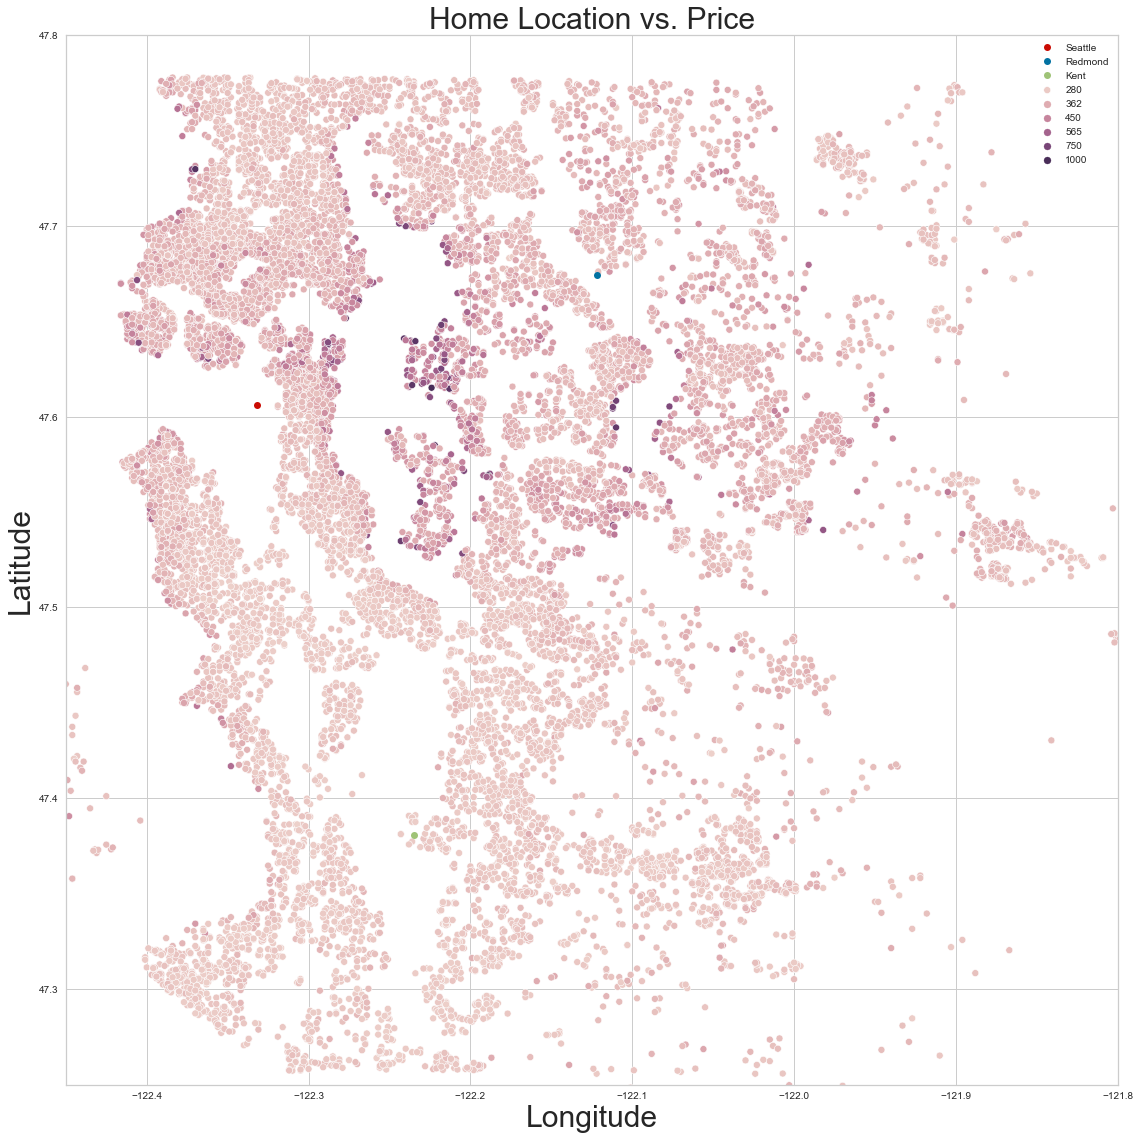

In [101]:
fig, ax = plt.subplots(figsize=(16, 16))
plt.title('Home Location vs. Price', fontsize=30)
sns.scatterplot(df['long'], df['lat'], hue=df_5['price'])

plt.xlabel('Longitude', fontsize=30)
plt.ylabel('Latitude', fontsize=30)
plt.legend([280,362,450,565,750,1000])
ax.plot(-122.3321, 47.6062, 'ro')
ax.plot(-122.1215, 47.6740, 'bo')
ax.plot(-122.2348, 47.3809, 'go')
ax.set_xlim(-122.45, -121.80)
ax.set_ylim(47.25, 47.80)
plt.legend(['Seattle', 'Redmond', 'Kent', 280,362,450,565,750,1000])
# plt.savefig('loc_price_2', bbox_inches='tight')
plt.tight_layout();

In [ ]:
model_coefficients = pd.DataFrame(model_5.params[1:], columns=['coefficients'])

In [ ]:
print("Final Regression Formula\n")
print(LR.intercept_, '+')
print('sum(')
for i in range(len(model_coefficients)):
    print(model_coefficients.coefficients[i], '*', model_coefficients.index[i])
print(')')


In [ ]:
LR.score(X_test, y_test) #r-squared

In [ ]:
sns.regplot(y_test, y_prediction);

In [ ]:
def model_diagnostic(model, x, x_name, y):
    
    residuals = model.resid
    
    f = plt.figure()
    f, axes = plt.subplots(nrows = 1, ncols = 3, sharex=False, sharey = False, figsize=(65,20), squeeze=False)
    
    f.text(s="Model Diagnostic Summary", x=.40, y=1.15, fontsize=65, fontname='silom')
    f.text(s="r-Squared: {r}".format(r=round(model.rsquared, 2)), x=.40, y=1.05, fontsize=50, fontname='serif')
    f.text(s="p-value: {p}".format(p= model.f_pvalue), x=.53, y=1.05, fontsize=50, fontname='serif')
    
    f.text(s='Residuals Histogram', x=.45, y=.93, fontsize=55, fontname='serif')
    
    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=axes[0][0])    
    plt.show;
    
    f.text(s='QQ Plot', x=.20, y=.93, fontsize=55, fontname='serif')
    
    axes[0][1].hist(residuals)
    plt.show;
    
    sns.residplot(x, y, ax=axes[0][2])
    
 
    f.text(s='Residuals vs {x}'.format(x=x_name), x=.73, y=.93, fontsize=55, fontname='serif')
    plt.tight_layout;
    plt.show;

In [ ]:
def model_diagnostic(model, x, x_name, y):
    
    residuals = model.resid
    fig, axes = plt.subplots(nrows = 1, ncols = 3, sharex=False, sharey = False, figsize=(65,20), squeeze=False)

    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=axes[0][0])      
    axes[0][1].hist(residuals)
    sns.residplot(x, y, ax=axes[0][2])
    plt.tight_layout;

### Transformations

In [ ]:
# df_6['price'] = np.log(df_6['price'])

In [ ]:
X = df_6.drop('price', axis=1)
y = np.log(df_6['price'])
model_6 = sm.OLS(y, sm.add_constant(X)).fit()
model_6.summary()

In [ ]:
# def clean_data_model_6(df):
#     df['price'] = np.log(df['price'])

#     return df

In [ ]:
# LR = LinearRegression()
# LR.fit(X,y)

# to_clean = X_test
# to_clean['price'] = y_test

# # Clean test according to cahnges so far
# cleaned_X_test_6 = clean_data_model_6(to_clean)

# y_test = cleaned_X_test_6['price']
# X_test = cleaned_X_test_6.drop('price', axis=1)

# y_prediction =  LR.predict(X_test)
# y_prediction

# rms = mean_squared_error(y_test, y_prediction, squared=False)
# rms

In [ ]:
df_5

In [ ]:
df_6['price'] = np.log(df_6['price'])

In [ ]:
f = 'price~sqft_living'
sqft_living_model = smf.ols(formula=f, data=df_6).fit()
residuals = sqft_living_model.resid
plt.figure(figsize=(12, 8))
fig = sm.graphics.qqplot(sqft_living_model.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.tight_layout();

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(sqft_living_model.predict(), sqft_living_model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Checking for Homoscedasticity');

In [ ]:
sns.distplot(sqft_living_model.resid);

In [ ]:
f = 'price~bedrooms'
bedrooms_model = smf.ols(formula=f, data=df_6).fit()
model_diagnostic(bedrooms_model, df['bedrooms'], 'bedrooms', df['price'])

In [ ]:
f = 'price~bathrooms'
bathrooms_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(bathrooms_model, df['bathrooms'], 'bathrooms', df['price'])

In [ ]:
f = 'price~sqft_living'
sqft_living_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(sqft_living_model, df['sqft_living'], 'sqft_living', df['price'])

In [ ]:
f = 'price~floors'
floors_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(floors_model, df['floors'], 'floors', df['price'])

In [ ]:
f = 'price~waterfront'
waterfront_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(waterfront_model, df['waterfront'], 'waterfront', df['price'])

In [ ]:
f = 'price~sqft_basement'
sqft_basement_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(sqft_basement_model, df['sqft_basement'], 'sqft_basement', df['price'])

In [ ]:
f = 'price~distance_seattle'
distance_seattle_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(distance_seattle_model, df['distance_seattle'], 'distance_seattle', df['price'])

In [ ]:
f = 'price~distance_redmond	'
distance_redmond_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(distance_redmond_model, df['distance_redmond'], 'distance_redmond', df['price'])

In [ ]:
X = df.drop('price', axis=1)
y = df['price']
model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary()

In [ ]:
sns.distplot(model_5.resid);

In [ ]:
fig = sm.graphics.qqplot(model_5.resid, dist=stats.norm, line='45', fit=True)

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(model.predict(), model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Checking for Homoscedasticity')

## Validating the Model

We fail to reject the null hypotesis here since the p-value is insignificant, so the model is homoscedastic.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':20}, pad=16);

## Checking Assumptions for Linear Regression

## sns.pairplot(df, y_vars=['price'])

In [ ]:
plt.scatter(x=df['sqft_living']**2, y=df['price'])

In [ ]:
df['sqft_living']**2

In [ ]:
# X = df.drop('price', axis=1)
for col in X.columns:
    plt.subplots(1, 1)
    sns.regplot(X[col], df.price)
    plt.title(col)